In [31]:
import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')
# from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
# from model_utils import *
from train import Parameters
%load_ext autoreload
%autoreload 2

from flax import linen as nn, struct
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from optax import (
    softmax_cross_entropy_with_integer_labels as xent
)
import jax
import jax.numpy as jnp
import optax
from jaxtyping import Int, Array, Float
from functools import partial
from dataclasses import dataclass
from frozendict import frozendict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
class MLP2(nn.Module):
    # right now this hardcodes a lot of things to the defaults
    cfg: frozendict
    N: int

    @nn.compact
    def __call__(self, a: Int[Array, 'batch entry']) -> Float[Array, 'batch vocab']:
        a1, a2 = a[...,0], a[...,1]
        embedding_init = nn.initializers.normal(stddev=1.0)
        # In the torch code, uniform bounds are \pm 1/sqrt(fan_in) * 1/sqrt(2) (kaiming_uniform with scale=1/sqrt(2) to account for 2 input arguments)
        # This corresponds to std = 1/sqrt(6) * 1/sqrt(fan_in)
        # variance_scaling sets std = sqrt(scale) / sqrt(fan_in)
        # So we should set scale = 1/6 to get the same initialization
        kernel_init = nn.initializers.variance_scaling(mode='fan_in', distribution='uniform', scale=1/6)
        # This differs from the pytorch version
        # In pytorch we had uniform distribution over [-1/sqrt(fan_in), 1/sqrt(fan_in)]
        # Here we use constant initialization to 1/N
        # The former matches the default for torch.nn.Linear, but it doesn't seem motivated by anything
        # and anyways I don't know how to recreate it with flax...
        bias_init = nn.initializers.constant(1 / self.N)
        # bias_init = nn.initializers.uniform(scale=1/np.sqrt(self.params.hidden_size))
        x1 = nn.Embed(self.N, self.cfg['embed_dim'], embedding_init=embedding_init, name='embedding_left')(a1)
        x2 = nn.Embed(self.N, self.cfg['embed_dim'], embedding_init=embedding_init, name='embedding_right')(a2)
        h1 = nn.Dense(self.cfg['hidden_size'], use_bias=False, kernel_init=kernel_init, name='linear_left')(x1)
        h2 = nn.Dense(self.cfg['hidden_size'], use_bias=False, kernel_init=kernel_init, name='linear_right')(x2)
        h = h1 + h2
        act = nn.relu(h)
        return nn.Dense(self.N, kernel_init=kernel_init, bias_init=bias_init, name='unembedding')(act)


In [33]:
def make_apply_full(model, unraveler):
    """Apply function that takes raveled params vector."""
    def apply_full(raveled, x):
        params = unraveler(raveled)
        return model.apply(params, x)
    
    return apply_full

def loss_fn(params, apply_fn, x, z):
    logits = apply_fn(params, x)
    preds = jnp.argmax(logits, axis=-1)
    loss = xent(logits, z).mean()
    acc = (preds == z).mean()
    return loss, acc

def wd_loss_fn(params, apply_fn, x, z, wd):
    loss, acc = loss_fn(params, apply_fn, x, z)
    return loss + wd / 2 * jnp.linalg.norm(params) ** 2, (loss, acc)

In [34]:
@partial(jax.jit, static_argnums=(3, 4))
def train(ravel_params, x, z, apply_fn, cfg: frozendict):
    tx = optax.adam(
        learning_rate=cfg['lr'],
        b1=cfg['beta1'],
        b2=cfg['beta2'],
    )
    
    state = TrainState.create(apply_fn=apply_fn, params=ravel_params, tx=tx)
    loss_and_grad = jax.value_and_grad(wd_loss_fn, has_aux=True)
    
    # TODO: support batching (right now only full batch)
    def epoch_step(state:TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        (_, (loss, acc)), grads = loss_and_grad(state.params, state.apply_fn, x, z, cfg['weight_decay'])
        return state.apply_gradients(grads=grads), (loss, acc)

    state, (train_loss, train_acc) = jax.lax.scan(epoch_step, state, jnp.arange(cfg['epochs']))
    return state.params, (train_loss, train_acc)
        

In [78]:
device = jax.devices('gpu')[0]

PARAMS = Parameters(
    instances=1,
    # embed_dim=32,
    # hidden_size=32,
    # group_string='S(4)',
    embed_dim=32,
    hidden_size=32,
    group_string='S(4)',
    model='MLP2',
    unembed_bias=True,
    weight_decay=2e-4,
    train_frac=0.6,
    epochs=4000,
)

t.manual_seed(PARAMS.seed)
np.random.seed(PARAMS.seed)
random.seed(PARAMS.seed)

group_dataset = GroupData(params=PARAMS)
train_data = jnp.array(group_dataset.train_data, device=device)

# Needs to be hashable for jax jit
CFG = frozendict(
    {k: v for k, v in PARAMS.__dict__.items() if k not in ['delta_frac']}
)


Intersection size: 576/576 (1.00)
Added 576 elements from intersection
Added 0 elements from group 0: S(4)
Taking random subset: 345/576 (0.60)
Train set size: 345/576 (0.60)


In [88]:
x_train, z_train = train_data[:,:2], train_data[:,2]
model = MLP2(CFG, group_dataset.N)
init_params = model.init(jax.random.key(PARAMS.seed), x_train)
init_ravel_params, unraveler = ravel_pytree(init_params)
apply_fn = make_apply_full(model, unraveler)

In [89]:
final_ravel_params, (train_loss, train_acc) = train(init_ravel_params, x_train, z_train, apply_fn, CFG)
train_loss[-1], train_acc[-1]

(Array(0.00673234, dtype=float32), Array(1., dtype=float32))

In [90]:
x_test = jnp.asarray(list(product(range(group_dataset.N), repeat=2)), device=device)
z_test = einops.rearrange(jnp.asarray(group_dataset.groups[0].cayley_table, device=device), 'i j -> (i j)')
loss_fn(final_ravel_params, apply_fn, x_test, z_test)

(Array(0.01418004, dtype=float32), Array(1., dtype=float32))

In [91]:
jac, _ = jax.jit(jax.jacfwd(train, has_aux=True), static_argnums=(3, 4,))(init_ravel_params, x_train, z_train, apply_fn, CFG)

In [92]:
jnp.save('/workspace/wilson/Finite-groups/data/trainjac_S4_d32_wd2e-4_epochs4000.npy', jac)

In [93]:
U, S, V = jnp.linalg.svd(jac)

In [97]:
jac

Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

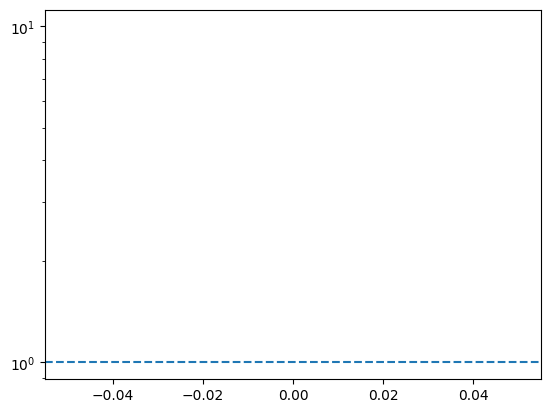

In [94]:
plt.plot(S)
plt.axhline(1, linestyle='--')
plt.yscale('log')
plt.show()